In [210]:
# same imports as part 1
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
# sklearn pipelines
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline # helper function

# A few classifiers
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import NuSVC
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
# available list of all classifiers https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

#prerprocessing 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Binarizer

# evaluation metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

# combinatory techniques
from sklearn.ensemble import VotingClassifier

# hyperparameter
from sklearn.utils.fixes import loguniform
from scipy import stats


# grid and randomized searches
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.calibration import CalibratedClassifierCV

In [62]:
from utils.samplegenerator import UserDataGenerator

# Generating and testing the data

In [69]:
# unbalanced label distribution 
label_frequency=[0.1,0.2,0.1,0.5,0.1]
colnames=['click_a','click_b','click_c','click_d','click_e','click_f','purchased_stock','response_time','more_chi_square','retrieved']
column_types=['binom','binom','binom','binom','binom','binom','categorical','chisquare','chisquare','norm']
n_labels=5

preset_spread = 60

#print(len(colnames) == len(column_types) )          

In [70]:
ug2 = UserDataGenerator(n_labels=n_labels, colnames=colnames, column_types=column_types, label_frequency=label_frequency, preset_spread=preset_spread)

In [154]:
# Generate Data
%time train_data = ug2.generate_user_df(10000)
test_data = ug2.generate_user_df(5000)

CPU times: user 14.6 s, sys: 18.4 ms, total: 14.6 s
Wall time: 14.6 s


In [167]:
# transfer categorical to one hot
def to_one_hot(data, categorical_cols):
    """
    extract categorical columns and change them to one hot encoding
    
    IN:
    dataframe Pd.df
    
    OUT:
    dataframe without labels
    label column
    
    
    """
    
    y_train = data['label']
    X_train = data[data.columns.tolist()[1:]]
    
    for element in categorical_cols:
        
        columns = X_train.columns.tolist()
        
        columns.remove(element)
        onehot_purchase = pd.get_dummies(X_train[element] )
        
        # adapt the default names
        newnames = { n : 'el'+ n for n in onehot_purchase.columns.tolist() }
        onehot_purchase.rename(newnames, axis='columns')
    
        
        X_train = pd.concat( [ X_train[columns],onehot_purchase ] 
                    , axis = 1)

    return X_train, y_train


In [171]:
X_train, y_train = to_one_hot(train_data, ['purchased_stock'])
X_test, y_test = to_one_hot(test_data, ['purchased_stock'])

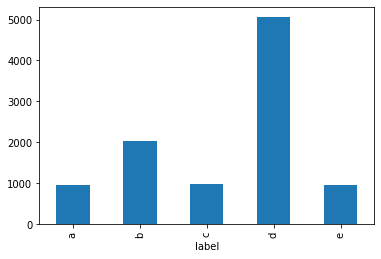

In [170]:
# Distribution plot
ax = train_data.groupby('label').size().plot(kind='bar') # overrepresenting label d
ax.set_label('Verteilung der Klassen')

# Scaling

In [172]:
# add scaler
stdscaler = StandardScaler()
# fit on train data
stdscaler.fit(X_train)

# transform the data
X_train_scaled = stdscaler.transform(X_train)
x_test_scaled = stdscaler.transform(X_test)

In [173]:
# Hyperparameter are specific to the data, since we create new data here, this has to be re-run
# Bounds of the individual Hyperparameters are set here

distributions =  { 'max_depth': stats.uniform(loc=8, scale=8), 
                  'n_estimators' :[40,50,70], 
                  'class_weight' : [None,'balanced'],
                 "max_features" : [ None, 'sqrt', 'log2' ,5,10,20]}

ada_dist = {'n_estimators':[40,50,70,100] , "learning_rate": np.linspace(0.1, 1, num=10) }

grad_dist = {'loss':['deviance'],
             'learning_rate': np.linspace(0.1, 1, num=10), 
             'n_estimators':[70,100,120], 
             'subsample':[0.5,1], 
             'max_depth': stats.uniform(loc=8, scale=8),
             'max_features' : [ None, 'sqrt', 'log2' ,5,10,20]}

scv_dist = {
    'nu':np.linspace(0.2, 0.4, num=10),
    'gamma': ['scale', 'auto' ],
    'decision_function_shape': ['ovo','ovr'],
    'kernel':['rbf','poly','sigmoid'],
    
}

gnb_dist = {
    "var_smoothing":loguniform(1e-10, 1e-8)
}

mlp_dist = {
    "hidden_layer_sizes":[80,100,200],
    "activation":['identity', 'logistic', 'tanh', 'relu'],
    "solver": ['lbfgs', 'sgd', 'adam'],
    "alpha":loguniform(1e-5, 1e-2),
    "learning_rate":['constant', 'invscaling', 'adaptive'],
    "learning_rate_init":loguniform(1e-4, 1e-1),
    'beta_1':np.linspace(0.9, 0.999, num=10),
}

In [174]:
rfc = RandomForestClassifier()
ada = AdaBoostClassifier()
gbc  = GradientBoostingClassifier()
#lsvc = LinearSVC(max_iter=2000)
svc  = NuSVC(0.2,probability=True)
gnbc = GaussianNB()
mlpc = MLPClassifier(max_iter=1000)

classifiers = [("Randomforest",rfc,distributions),
               #("AdaBoostClassifier",ada,ada_dist),
               ("Gradientboosting",gbc,grad_dist),
               #("LinearSVC",lsvc), # no predict probability method
               #("SVC" ,svc,scv_dist),
               ("GaussianNB", gnbc,gnb_dist),
               ("MLPClassifier", mlpc,mlp_dist) ]

In [175]:
param_dict = {}

for (name, classifier, dists) in classifiers:
    
    print(f"Processing : {name}")
    search_random = RandomizedSearchCV(classifier, dists, random_state=0)
    search_random.fit(X=X_train_scaled, y=y_train)
    
    print(search_random.best_score_)
    param_dict[name] = search_random.best_params_
    #classifier.fit(X=X_train_scaled, y=y_train)
    #print(f""" Algorithmus {name} 
    #            : validation score of {classifier.score(x_test_scaled, y_test )} 
    #            : crossvalidation score {cross_val_score(classifier, X=X_train_scaled, y=y_train).mean()}" )

Processing : Randomforest
0.9454
Processing : Gradientboosting


/home/ethuer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/ethuer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/ethuer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/ethuer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/model_selec

0.9442
Processing : GaussianNB
0.9327000000000002
Processing : MLPClassifier


/home/ethuer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ethuer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ethuer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs fa

0.9530000000000001


In [177]:
# best parameters
param_dict

{'Randomforest': {'class_weight': 'balanced',
  'max_depth': 14.393268513733789,
  'max_features': 5,
  'n_estimators': 50},
 'Gradientboosting': {'learning_rate': 0.1,
  'loss': 'deviance',
  'max_depth': 12.656158336600857,
  'max_features': 'sqrt',
  'n_estimators': 70,
  'subsample': 1},
 'GaussianNB': {'var_smoothing': 1.2520653814999461e-09},
 'MLPClassifier': {'activation': 'identity',
  'alpha': 0.007780155576901415,
  'beta_1': 0.911,
  'hidden_layer_sizes': 200,
  'learning_rate': 'adaptive',
  'learning_rate_init': 0.00505980387466043,
  'solver': 'sgd'}}

In [191]:
rfc = RandomForestClassifier(class_weight=  'balanced',
  max_depth= 14,
  max_features= 5,
  n_estimators= 50)

ada = AdaBoostClassifier(n_estimators= 50, learning_rate= 0.5)
gbc  = GradientBoostingClassifier(learning_rate= 0.1,
  loss= 'deviance',
  max_depth= 13,
  max_features= 'sqrt',
  n_estimators= 70,
  subsample= 1)
#lsvc = LinearSVC(max_iter=2000)
svc  = NuSVC(nu= 0.2888888888888889,
  kernel= 'rbf',
  gamma= 'auto',
  decision_function_shape= 'ovr',
  probability=True)
gnbc = GaussianNB(var_smoothing= 1.2520653814999461e-09)
mlpc = MLPClassifier(activation= 'identity',
  alpha= 0.007780155576901415,
  beta_1= 0.911,
  hidden_layer_sizes= 200,
  learning_rate= 'adaptive',
  learning_rate_init= 0.00505980387466043,
  solver= 'sgd',
                    max_iter = 1000)

classifiers = [("Randomforest",rfc),
               #("AdaBoostClassifier",ada),
               ("Gradientboosting",gbc),
               #("LinearSVC",lsvc), # no predict probability method
               #("SVC" ,svc),
               ("GaussianNB", gnbc),
               ("MLPClassifier", mlpc) ]

# Define the pipeline

In [207]:
# combine the classifiers and fit
voting = VotingClassifier(estimators= classifiers, voting='soft')

In [208]:
# set pipeline
pipe = Pipeline(steps=[('scaling', stdscaler),('classifier',voting)])

In [194]:
# fit the pipeline directly
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('scaling',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classifier',
                 VotingClassifier(estimators=[('Randomforest',
                                               RandomForestClassifier(bootstrap=True,
                                                                      ccp_alpha=0.0,
                                                                      class_weight='balanced',
                                                                      criterion='gini',
                                                                      max_depth=14,
                                                                      max_features=5,
                                                                      max_leaf_nodes=None,
                                                                      max_samples=None,
                                                                      min_imp

In [197]:
print(f'The pipeline reaches a score of : {cross_val_score(pipe, X=X_test, y=y_test).mean() } ' )

The pipeline reaches a score of : 0.9458 


In [199]:
y_pred = pipe.predict(X_test)
y_true = np.asarray(y_test)
c_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)

Text(0.5, 1.0, 'Confusion Matrix')

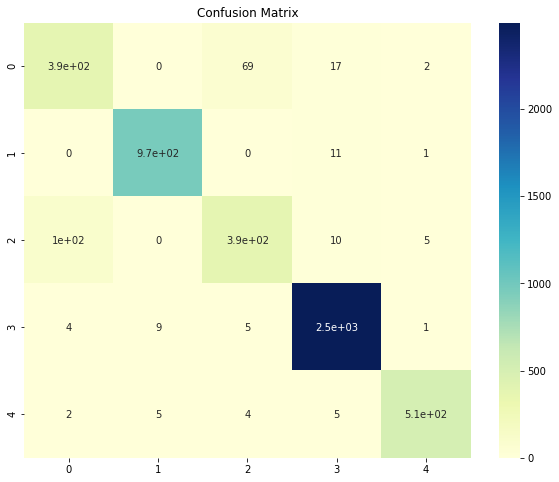

In [200]:
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(c_mat, annot=True, cmap="YlGnBu",ax=ax)
ax.set_title('Confusion Matrix')

# Test some performance metrics

In [ ]:
# Generate testdata in ranges
test_data = ug2.generate_user_df(5000)
X_test, y_test = to_one_hot(test_data, ['purchased_stock'])

In [214]:
y_test

0    d
0    d
0    a
0    e
0    d
    ..
0    d
0    b
0    d
0    b
0    b
Name: label, Length: 5000, dtype: object

In [38]:
# what is the relationship between available data and performance for machine learning pipelines ?

In [ ]:
# lets quantify by producing 500 samples in various sizes and testing them

score_dict = {}

for n in tqdm(range(1,100) ):
    for replica in range(5):
        user_number = n*20
        
        
        
        
        
        # reset pipeline 
        pipe = Pipeline(steps=[('scaling', stdscaler),('classifier',voting)])
        
        # generate new samples
        train_data_iter = ug2.generate_user_df(user_number)
        X_train, y_train = to_one_hot(train_data_iter, ['purchased_stock'])
        
        rdf2 = RandomForestClassifier()
        rdf2.fit(X_train,y_train)
        print(X_train.shape)
        print(user_number,cross_val_score(rdf2, X=X_train, y=y_train).mean())
        
        # fit trainings set with optimized parameters
        pipe.fit(X_train,y_train)
        accuracy = cross_val_score(pipe, X=X_test, y=y_test).mean()
        print(accuracy, X_train.shape )
        # evaluate on test set
        score_dict[f'{n}-{replica}'] = {'user':user_number, 'score':accuracy}





  0%|          | 0/99 [00:00<?, ?it/s]/home/ethuer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


(20, 14)
20 0.7


In [206]:
score_dict

{'1-0': {'user': 100, 'score': 0.9448000000000001},
 '1-1': {'user': 100, 'score': 0.9454},
 '1-2': {'user': 100, 'score': 0.9456},
 '1-3': {'user': 100, 'score': 0.9468},
 '1-4': {'user': 100, 'score': 0.9461999999999999},
 '2-0': {'user': 200, 'score': 0.9458},
 '2-1': {'user': 200, 'score': 0.9463999999999999},
 '2-2': {'user': 200, 'score': 0.9452},
 '2-3': {'user': 200, 'score': 0.9466000000000001},
 '2-4': {'user': 200, 'score': 0.9465999999999999},
 '3-0': {'user': 300, 'score': 0.9456},
 '3-1': {'user': 300, 'score': 0.9461999999999999},
 '3-2': {'user': 300, 'score': 0.9446},
 '3-3': {'user': 300, 'score': 0.9458},
 '3-4': {'user': 300, 'score': 0.9451999999999998},
 '4-0': {'user': 400, 'score': 0.9443999999999999},
 '4-1': {'user': 400, 'score': 0.9453999999999999},
 '4-2': {'user': 400, 'score': 0.9471999999999999},
 '4-3': {'user': 400, 'score': 0.9461999999999999},
 '4-4': {'user': 400, 'score': 0.9453999999999999},
 '5-0': {'user': 500, 'score': 0.9453999999999999},
 '5-